# Importing Libraries.

In [1]:
import numpy as np
import tarfile
import cv2
import scipy.io
import os
import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
np.random.seed(0)

In [2]:
def loadDataset(path):
    
    tar = 'cifar-10-python.tar.gz'
    files = ['data_batch_1.bin', 'data_batch_2.bin', 'data_batch_3.bin', 'data_batch_4.bin', 'data_batch_5.bin', 'test_batch.bin']

    os.makedirs(path, exist_ok=True)

    with tarfile.open(os.path.join(path, tar)) as tar_object:
            # Each file contains 10,000 color images and 10,000 labels
            fsize = 10000 * (32 * 32 * 3) + 10000

            # There are 6 files (5 train and 1 test)
            buffr = np.zeros(fsize * 6, dtype='uint8')

            # Get members of tar corresponding to data files
            # -- The tar contains README's and other extraneous stuff
            members = [file for file in tar_object if file.name in files]

            # Sort those members by name
            # -- Ensures we load train data in the proper order
            # -- Ensures that test data is the last file in the list
            members.sort(key=lambda member: member.name)

            # Extract data from members
            for i, member in enumerate(members):
                # Get member as a file object
                f = tar_object.extractfile(member)
                # Read bytes from that file object into buffr
                buffr[i * fsize:(i + 1) * fsize] = np.frombuffer(f.read(), 'B')

    # Parse data from buffer
        # -- Examples are in chunks of 3,073 bytes
        # -- First byte of each chunk is the label
        # -- Next 32 * 32 * 3 = 3,072 bytes are its corresponding image

        # Labels are the first byte of every chunk
    labels = buffr[::3073]

        # Pixels are everything remaining after we delete the labels
    pixels = np.delete(buffr, np.arange(0, buffr.size, 3073))
    images = pixels.reshape(-1, 3072).astype('float32') / 255
    
    return images, labels

# Data Loading

In [3]:
train, label  = loadDataset(r'C:\Users\Mudasser Afzal\Desktop\deep ass 4')

In [4]:
training = []
for i in range(len(train)):
    img = train[i].reshape(3, 32, 32)
    img = np.rollaxis(img,0,3)
    training.append(img)

In [5]:
training = np.array(training)
training.shape

(60000, 32, 32, 3)

In [6]:
train_set_x, train_set_y = shuffle(training, label)

# reshape and Flattening Data

In [7]:
train_set_y = np.expand_dims(train_set_y, axis = 1)

In [8]:
print("train_x shape:", train_set_x.shape)
print("train_y shape:", train_set_y.shape)

train_x shape: (60000, 32, 32, 3)
train_y shape: (60000, 1)


# Mean subtraction and normalization

In [9]:
train_set_x = (train_set_x - int(np.mean(train_set_x))) / 255
# test_set_x = (test_set_x - int(np.mean(test_set_x))) / 255


# Encoding of labels

In [10]:
def encoder(Y):
    c = np.arange(10)
    encoding = (c == Y).astype(np.int)
    return encoding

train_set_y = encoder(train_set_y)

In [11]:
print("train_x shape:", train_set_x.shape)
print("train_y shape:", train_set_y.shape)


train_x shape: (60000, 32, 32, 3)
train_y shape: (60000, 10)


# Reading filters

In [12]:
filters = []
for i in range(0,36):
    filters.append(np.random.randn(17,17))
filters = np.array(filters)
filters = filters.reshape(filters.shape[1], filters.shape[2], filters.shape[0])
print(filters.shape)

(17, 17, 36)


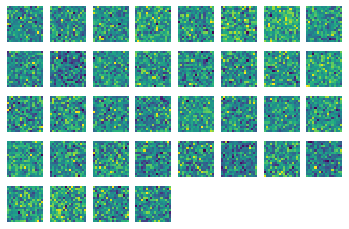

In [13]:
depth = filters.shape[2]
for i in range(depth):
    plt.subplot(5,8,i+1)
    plt.axis('off')
    plt.imshow(filters[:,:,i])

In [14]:
depth = filters.shape[2]
for i in range(depth):
    print(filters[:,:,i])

[[ 1.29684284 -1.3804499  -0.25004522  0.30292613  0.59444803 -0.55521685
   0.86847997 -0.42179855  1.90719029  1.6163181   1.06936916 -2.23184455
   0.04621313 -1.97983898  2.15755117  0.94519795  0.69640355]
 [-1.29296794 -0.30833742 -1.32066378  0.37297403 -0.58306325  0.1136533
  -2.08613243 -0.94696854 -0.28719113  0.08953621  0.97624242 -1.12982151
   0.09800566  1.15552484  0.63250487 -0.41796825 -0.47676125]
 [ 1.07537718  1.41415536  0.54149864  0.32397774  1.87305252 -0.62233604
  -1.2981413  -1.51994048  0.22351316  1.76868658 -0.21398787  0.62886321
  -0.57157429 -0.30531914  0.07977856  0.65934438  1.40186688]
 [-0.42188888  1.10971162 -0.09374108  1.58607637 -0.24815358  0.65304158
   0.01895107 -0.98835984 -1.6738639   0.69844362 -0.70034119  1.44622647
   0.51341839  0.69391788  0.12167549  0.7604041   0.11540128]
 [ 1.83966928 -0.31016747  1.67489279 -0.96386186 -0.13052085  0.54809543
  -0.02219409 -1.73854634  1.58576231 -0.47019836 -1.51403885 -0.673575
  -0.076361

# Convolution and Pooling

In [15]:
def conv_single_step(image, filter):
    s = np.multiply(image, filter)
    Z = np.sum(s)
    return Z

In [33]:
def conv_forward(img, filters, stride=1, pad=0):
#     print(img.shape)
    output_size_H = int(((img.shape[1] - len(filters) + (2 * pad)) / stride) + 1)
    output_size_W = int(((img.shape[0] - len(filters) + (2 * pad)) / stride) + 1)
#     print("the shape of output will be :", output_size_H, output_size_W)

    Z = np.zeros([output_size_H, output_size_W, filters.shape[2]])
    for d in range(filters.shape[2]):
        a = filters[:,:,d]
        for channel in range(img.shape[2]):
            image = img[:,:,channel]
            for j in range(0, output_size_H):
                for k in range(0, output_size_W):
                    img_patch = image[(j*stride):(j*stride)+(filters.shape[1]), (k*stride):(k*stride)+(filters.shape[0])]
                    Z[j, k, d] = conv_single_step(img_patch, a)
            Z[j, k, d] += Z[j, k, d]

    return Z

def pool_forward(feature_map, mode = "max", filter_size=2, stride=2):
    
    pool_size_H = int(((feature_map.shape[0] - filter_size) / (stride)) + 1)
    pool_size_W = int(((feature_map.shape[1] - filter_size) / (stride)) + 1)
#     print("the shape of output after pooling will be :", pool_size_H,"x", pool_size_W)
    
    A = np.zeros([pool_size_H, pool_size_W, feature_map.shape[2]])
    for d in range(feature_map.shape[2]):
        for j in range(0, pool_size_H):
            for k in range(0, pool_size_W):
                img_patch = feature_map[(j*stride):(j*stride)+(filter_size), (k*stride):(k*stride)+(filter_size)]
                if mode == "max":        
                    A[j, k, d] = np.max(img_patch)
                elif mode == "average":
                    A[j, k, d] = np.mean(img_patch)
    return A


def pool_backward(feature_map, mode = "max", filter_size=2, stride=2):
    
    pool_size_H = int(((feature_map.shape[0] - filter_size) / (stride)) + 1)
    pool_size_W = int(((feature_map.shape[1] - filter_size) / (stride)) + 1)
    dA_prev = np.zeros(feature_map.shape)
    for d in range(feature_map.shape[2]):
        for j in range(0, pool_size_H):
            for k in range(0, pool_size_W):
                img_patch = feature_map[(j*stride):(j*stride)+(filter_size), (k*stride):(k*stride)+(filter_size)]
                if mode == "max":
                    mask = img_patch == np.max(img_patch)
                    dA_prev[(j*stride):(j*stride)+(filter_size), (k*stride):(k*stride)+(filter_size)] += \
                    np.multiply(mask, feature_map[j,k,d])
                    
    return dA_prev


def conv_backward(img, learningRate, filters, stride=1, pad=0):
#     print(img.shape)
    output_size_H = int(((img.shape[1] - len(filters) + (2 * pad)) / stride) + 1)
    output_size_W = int(((img.shape[0] - len(filters) + (2 * pad)) / stride) + 1)
    
    
    dW = np.zeros((filters.shape[1], filters.shape[0], img.shape[2], filters.shape[2]))
    
#     Z = np.zeros([output_size_H, output_size_W, filters.shape[2]])
    for d in range(filters.shape[2]):
        a = filters[:,:,d]
        for j in range(0, output_size_H):
            for k in range(0, output_size_W):
                img_patch = img[(j*stride):(j*stride)+(filters.shape[1]), (k*stride):(k*stride)+(filters.shape[0])]
                img_patch += (img_patch * a)
                dW += img_patch * a
                filters = filters - (learningRate * dW)

    return dW, filters

In [17]:
# depth = A.shape[2]
# for i in range(depth):
#     plt.subplot(5,8,i+1)
#     plt.axis('off')
#     plt.imshow(A[:,:,i])

# Data partition

In [18]:
trainX = train_set_x[:40000]
trainY = train_set_y[:40000]
validX = train_set_x[40000:50000]
validY = train_set_y[40000:50000]
testX = train_set_x[50000:]
testY = train_set_y[50000:]

In [19]:
print("training data shape:", trainX.shape)
print("training label shape:", trainY.shape)
print("validation data shape:", validX.shape)
print("validation label shape:", validY.shape)
print("testing data shape:", testX.shape)
print("testing label shape:", testY.shape)

training data shape: (40000, 32, 32, 3)
training label shape: (40000, 10)
validation data shape: (10000, 32, 32, 3)
validation label shape: (10000, 10)
testing data shape: (10000, 32, 32, 3)
testing label shape: (10000, 10)



# Neural network architecture

In [31]:
class Neural_Network(object):
    
    def __init__(self, neurons_per_layer, no_of_layers = 2, inputSize = 2304):        
        # size of layers
        self.inputSize = inputSize
        self.hidden1 = neurons_per_layer[0]
        self.hidden2 = neurons_per_layer[1]
        self.outputSize = neurons_per_layer[2] 
        #weights
        self.model = {}
        w1 = np.random.randn(self.inputSize, self.hidden1) #1296x128
        b1 = np.ones((1,self.hidden1))
        w2 = np.random.randn(self.hidden1, self.hidden2)   #128x64
        b2 = np.ones((1,self.hidden2))
        w3 = np.random.randn(self.hidden2, self.outputSize) #64x10
        b3 = np.ones((1,self.outputSize))

        self.model = {'w1': w1 , 'b1': b1, 'w2': w2 , 'b2': b2, 'w3': w3 , 'b3': b3}  
        
    def sigmoid(self, s):
        activated_output = 1 / (1 + (np.exp(-s)))
        return activated_output

    def sigmoid_derivative(self, s):
        return s * (1 - s)

    def softmax(self, s):
        e = np.exp(s - np.max(s))
        return e/ np.sum(e, axis=1, keepdims=True)

    def softmax_derivative(self, s):
        z = self.softmax(s)
        D = -np.outer(z, z) + np.diag(z.flatten())
        return D
    
    def feedforward(self, X):
        forward_result = {}
        
        w1, b1, w2, b2, w3, b3 = self.model['w1'], self.model['b1'], self.model['w2'], self.model['b2'], self.model['w3'], self.model['b3']
        
        z1 = X.dot(w1) + b1
        a1 = self.sigmoid(z1)
       
        z2 = a1.dot(w2) + b2
        a2 = self.sigmoid(z2)
    
        z3 = a2.dot(w3) + b3
        a3 = self.softmax(z3)

        forward_result = {'z1': z1 , 'a1': a1, 'z2': z2 , 'a2': a2, 'z3': z3 , 'a3': a3}
        return forward_result
    
    def back_propagation(self, X, Y, forward_result, lr):
        
        w1, b1, w2, b2, w3, b3 = self.model['w1'],self.model['b1'], self.model['w2'],self.model['b2'], \
        self.model['w3'],self.model['b3']
        
        gradient = {}
    
        a1, a2, a3 = forward_result['a1'], forward_result['a2'], forward_result['a3']
    
        m = X.shape[0]
        
        delta_out = a3 - Y
        delta_w3 = 1/m * np.dot(a2.T, delta_out)
        delta_b3 = 1/m * np.sum(delta_out, axis=0, keepdims = True)
        
        delta_h2 = np.multiply(np.dot(delta_out, w3.T) , self.sigmoid_derivative(a2))
        delta_w2 = 1/m * np.dot(a1.T, delta_h2)
        delta_b2 = 1/m * np.sum(delta_h2, axis=0, keepdims = True)
        

        delta_h1 = np.multiply(np.dot(delta_h2, w2.T) , self.sigmoid_derivative(a1))
        delta_w1 = 1/m * np.dot(X.T, delta_h1)
        delta_b1 = 1/m * np.sum(delta_h1, axis=0, keepdims = True)
        
        delta_h0 = np.dot(delta_h1 , w1.T)
        
        gradient = {'dw3':delta_w3, 'db3':delta_b3, 'dw2':delta_w2, 'db2':delta_b2, 'dw1':delta_w1,'db1':delta_b1}
        return delta_h0, gradient
    
       
    def weight_update(self, model, gradient, lr):
        
 ###################### weight Updating here #####################
        
        self.model['w1'] = self.model['w1'] - (lr * gradient['dw1'])
        self.model['b1'] = self.model['b1'] - (lr * gradient['db1'])
        self.model['w2'] = self.model['w2'] - (lr * gradient['dw2'])
        self.model['b2'] = self.model['b2'] - (lr * gradient['db2'])
        self.model['w3'] = self.model['w3'] - (lr * gradient['dw3'])
        self.model['b3'] = self.model['b3'] - (lr * gradient['db3'])
            
    def crossentropy(self, Y, Y_pred):
        return (-np.sum(Y * np.log2(Y_pred+1e-12)))# / len(Y)
    
    
    def kygo(self, array, images):
        array = []
        for img in images:
            Z = conv_forward(img, filters, stride=1, pad=0)
            A = pool_forward(Z, mode = "max", filter_size=2, stride=2)
            array.append(A)
                
        array = np.asarray(array)
        L_val = array.flatten().reshape(array.shape[0],(array.shape[1] * array.shape[2]* array.shape[3]))
        
        return L_val, array
    
    def batch_gradient(self, batch_size, trainX, trainY, learningRate):
        
        for j in range(0, trainX.shape[0], batch_size):
            X = trainX[j:j+batch_size]
            Y = trainY[j:j+batch_size]
            training = []
    ############################################################################################################        
            L, training = self.kygo(training, X)
            forward_result = self.feedforward(L)
            fu, gradient = self.back_propagation(L, Y, forward_result, learningRate)
            self.weight_update(self.model, gradient, learningRate)
            
            back = fu.reshape(training.shape[0], training.shape[1],training.shape[2],training.shape[3])
        
            H = pool_backward(back, mode = "max", filter_size=2, stride=2)
            G, filt = conv_backward(H, learningRate, filters, stride=1, pad=0)
#             filters = filters - (learningRate * G)

    def train(self, trainX, trainY, batch_size, epochs, learningRate,validationX = 'None', validationY = 'None'):
        
        
        train_error = []
        valid_error = []
        valid_accu = []
        train_accu = []
        
        for i in range(epochs):
            
            self.batch_gradient(batch_size, trainX, trainY, learningRate)
            train = []

            L_train, arr = self.kygo(train, trainX)
            train_pred = self.feedforward(L_train)
            entropy = self.crossentropy(trainY, train_pred['a3'])
            train_error.append(entropy)
            
            taccu = self.accuracy(L_train, trainY)
            train_accu.append(taccu)
            
            val = []
            L_val, arr = self.kygo(val, validationX)
            val_pred = self.feedforward(L_val)
            err = self.crossentropy(validationY, val_pred['a3'])
            valid_error.append(err)                

            accu= self.accuracy(L_val, validationY)
            valid_accu.append(accu)
            
            print ("epoch:",i, "training Loss:" ,entropy, "validation Loss:", valid_error[-1] \
                   ,  "validation accuracy", valid_accu[-1], "train accuracy", taccu)
            
        self.curve_plot(epochs, train_error, valid_error, train_accu, valid_accu)
        
    def curve_plot(self, epochs, train_error, valid_error, train_accu, valid_accu):
        
        plt.legend(loc='best')
        plt.title("loss curve")
        plt.plot(range(epochs), train_error)
        plt.plot(range(epochs), valid_error)
        plt.show()
        plt.legend(loc='best')
        plt.title("accuracy Curve")
        plt.plot(range(epochs), train_accu)
        plt.plot(range(epochs), valid_accu)
        plt.show()

    def predict(self, X):
        predict = []


        forward_result = self.feedforward(X)
        return forward_result['a3']
    
    def accuracy(self, X, Y):
    
        test_pred = self.predict(X)
        pred = np.argmax(test_pred, axis=1)
        y = np.argmax(Y, axis=1)        
        accuracy = (pred == y)
        accuracy = np.mean(accuracy)
        return accuracy * 100
        
    def saveModel(self, name):
        np.savez(name, self.model['w1'],self.model['b1'],self.model['w2'],\
                 self.model['b2'],self.model['w3'],self.model['b3'], allow_pickle=True)
        
    def loadModel(self,name):
        file = np.load(name, allow_pickle=True)
        self.model['w1'] = file['arr_0']
        self.model['b1'] = file['arr_1']
        self.model['w2'] = file['arr_2']
        self.model['b2'] = file['arr_3']
        self.model['w3'] = file['arr_4']
        self.model['b3'] = file['arr_5']

epoch: 0 training Loss: 16.877446005397506 validation Loss: 3.3754892010794997 validation accuracy 100.0 train accuracy 100.0
epoch: 1 training Loss: 7.411664161740565 validation Loss: 1.4823328323481122 validation accuracy 100.0 train accuracy 100.0
epoch: 2 training Loss: 5.026465290277651 validation Loss: 1.0052930580555297 validation accuracy 100.0 train accuracy 100.0
epoch: 3 training Loss: 3.844810432908782 validation Loss: 0.7689620865817567 validation accuracy 100.0 train accuracy 100.0
epoch: 4 training Loss: 3.127362950144279 validation Loss: 0.6254725900288556 validation accuracy 100.0 train accuracy 100.0
epoch: 5 training Loss: 2.642083877916339 validation Loss: 0.5284167755832676 validation accuracy 100.0 train accuracy 100.0
epoch: 6 training Loss: 2.2906542502381795 validation Loss: 0.45813085004763593 validation accuracy 100.0 train accuracy 100.0
epoch: 7 training Loss: 2.0237984047713593 validation Loss: 0.40475968095427184 validation accuracy 100.0 train accuracy 1

No handles with labels found to put in legend.


epoch: 19 training Loss: 0.8579599943066792 validation Loss: 0.17159199886133558 validation accuracy 100.0 train accuracy 100.0


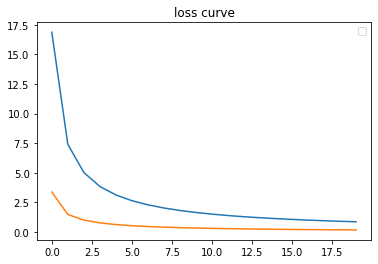

No handles with labels found to put in legend.


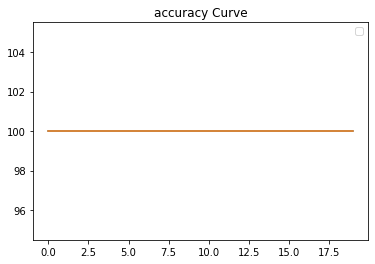

In [34]:
nn = Neural_Network([128,64,10])
nn.train(trainX[:50], trainY[:50], batch_size = 128, epochs = 20, \
         learningRate = 0.1, validationX = validX[:10], validationY = validY[:10])

In [ ]:
depth = filters.shape[2]
for i in range(depth):
    print(filters[:,:,i])

In [35]:
nn.saveModel("BestModelCNN")

In [ ]:
nn.loadModel('BestModelCNN.npz')
array = []
testX, array = nn.kygo(array, testX)
nn.accuracy(testX,testY)